# Imports and configs

In [1]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import matplotlib.pyplot as plt
from scipy.special import logit
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import optuna
import glob
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e10/train.csv'
    test_path = '/kaggle/input/playground-series-s4e10/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e10/sample_submission.csv'
    
    oof_path = '/kaggle/input/s04e10-loan-approval-prediction-autogluon'
    
    target = 'loan_status'
    n_folds = 5
    seed = 1859

# Loading OOF files

In [3]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]

In [4]:
def get_data(oof_path, test_oof_path):
    oof_pred_probs = pickle.load(open(oof_path, 'rb'))
    test_pred_probs = pickle.load(open(test_oof_path, 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]   
        score = roc_auc_score(y_val, y_pred_probs)
        scores.append(score)
        
    return oof_pred_probs, test_pred_probs, scores

In [5]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [6]:
oof_paths = glob.glob(f'{CFG.oof_path}/oof_pred_probs/**')
test_oof_paths = glob.glob(f'{CFG.oof_path}/test_pred_probs/**')
for oof_path, test_oof_path in zip(oof_paths, test_oof_paths):
    model_name = oof_path.split('/')[-1][:-28]
    if "L1" in model_name and "PSEUDO" in model_name:
        oof_pred_probs[model_name], test_pred_probs[model_name], scores[model_name] = get_data(oof_path, test_oof_path)

# L2 Logistic Regression

In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            iters = model.n_iter_
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:, 1]
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - AUC: {score:.6f}' + ('' if isinstance(self.model, Ridge) else f' ({iters[0]} iterations)'))
            
        overall_score = roc_auc_score(y, oof_pred_probs)
        
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')   
        
        return oof_pred_probs, test_pred_probs, scores
    
    def fit(self, X, y):
        scores = []                
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect() 
        
        return np.mean(scores)

In [8]:
def save_submission(name, test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)
    return sub.head()

In [9]:
l2_oof_pred_probs = {}
l2_test_pred_probs = {}

In [10]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [11]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'max_iter': 1000,
        'C': trial.suggest_float('C', 0, 1),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2)
    }
    model = LogisticRegression(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=250, n_jobs=-1)
lr_params = study.best_params

[I 2024-10-08 09:18:42,277] A new study created in memory with name: no-name-26ef0cfd-c563-460a-94f8-cf909f9489ab
[I 2024-10-08 09:19:27,637] Trial 0 finished with value: 0.9637737468695178 and parameters: {'C': 0.6142235249907925, 'tol': 0.0040912468429021576}. Best is trial 0 with value: 0.9637737468695178.
[I 2024-10-08 09:19:28,451] Trial 1 finished with value: 0.9637788068360743 and parameters: {'C': 0.46199854458347134, 'tol': 0.006429057006325285}. Best is trial 1 with value: 0.9637788068360743.
[I 2024-10-08 09:19:31,099] Trial 2 finished with value: 0.9637724015137039 and parameters: {'C': 0.7972468315942141, 'tol': 0.009482902405690006}. Best is trial 1 with value: 0.9637788068360743.
[I 2024-10-08 09:19:31,582] Trial 3 finished with value: 0.9637767114146298 and parameters: {'C': 0.6226110045876109, 'tol': 0.004626947139547439}. Best is trial 1 with value: 0.9637788068360743.
[I 2024-10-08 09:20:12,747] Trial 4 finished with value: 0.9637870694638162 and parameters: {'C': 0.

In [12]:
lr_model = LogisticRegression(random_state=CFG.seed, max_iter=1000, **lr_params)
lr_trainer = Trainer(lr_model)
l2_oof_pred_probs['LR_Ensemble_L2'], l2_test_pred_probs['LR_Ensemble_L2'], scores['LR_Ensemble_L2'] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - AUC: 0.967131 (143 iterations)
--- Fold 2 - AUC: 0.965106 (155 iterations)
--- Fold 3 - AUC: 0.963681 (133 iterations)
--- Fold 4 - AUC: 0.960706 (147 iterations)
--- Fold 5 - AUC: 0.962968 (111 iterations)

------ Overall: 0.963926 | Average: 0.963918 ± 0.002145


In [13]:
save_submission('lr-ensemble-l2', l2_test_pred_probs['LR_Ensemble_L2'], np.mean(scores['LR_Ensemble_L2']))

,id,loan_status
0,58645,0.999302
1,58646,0.054545
2,58647,0.498288
3,58648,0.011709
4,58649,0.079454


# L2 Ridge

In [14]:
X = pd.DataFrame(oof_pred_probs)
X_test = pd.DataFrame(test_pred_probs)

In [15]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 50),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2),
        'positive': trial.suggest_categorical('positive', [True, False])
    }
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=250, n_jobs=-1)
ridge_params = study.best_params

[I 2024-10-08 09:54:07,009] A new study created in memory with name: no-name-15dce8c4-657f-46c2-8074-4272e195605c
[I 2024-10-08 09:54:09,602] Trial 2 finished with value: 0.9633245647089359 and parameters: {'alpha': 39.08657239808651, 'tol': 0.005452416688760108, 'positive': False}. Best is trial 2 with value: 0.9633245647089359.
[I 2024-10-08 09:54:10,436] Trial 3 finished with value: 0.9621739283139655 and parameters: {'alpha': 26.914711347831936, 'tol': 0.002213458372461755, 'positive': True}. Best is trial 2 with value: 0.9633245647089359.
[I 2024-10-08 09:54:10,587] Trial 1 finished with value: 0.9620504294125736 and parameters: {'alpha': 28.824312226150823, 'tol': 0.009790547165096445, 'positive': True}. Best is trial 2 with value: 0.9633245647089359.
[I 2024-10-08 09:54:11,982] Trial 0 finished with value: 0.9626650546208507 and parameters: {'alpha': 48.381445251854785, 'tol': 0.00022345560796112977, 'positive': True}. Best is trial 2 with value: 0.9633245647089359.
[I 2024-10-0

In [16]:
ridge_model = Ridge(random_state=CFG.seed, **ridge_params)
ridge_trainer = Trainer(ridge_model)
l2_oof_pred_probs['Ridge_Ensemble_L2'], l2_test_pred_probs['Ridge_Ensemble_L2'], scores['Ridge_Ensemble_L2'] = ridge_trainer.fit_predict(X, y, X_test)

Training Ridge

--- Fold 1 - AUC: 0.966790
--- Fold 2 - AUC: 0.965064
--- Fold 3 - AUC: 0.963379
--- Fold 4 - AUC: 0.959296
--- Fold 5 - AUC: 0.962137

------ Overall: 0.963329 | Average: 0.963333 ± 0.002556


In [17]:
save_submission('ridge-ensemble-l2', l2_test_pred_probs['Ridge_Ensemble_L2'], np.mean(scores['Ridge_Ensemble_L2']))

,id,loan_status
0,58645,0.981266
1,58646,0.033583
2,58647,0.555845
3,58648,0.009325
4,58649,0.078170


# L3 weighted ensemble

In [18]:
def objective(trial):
    weights = [trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_pred_probs.keys()]
    weights /= np.sum(weights)
    weights = [round(w, 3) for w in weights]
    
    preds = np.zeros(X.shape[0])
    for model, weight in zip(l2_oof_pred_probs.keys(), weights):
        preds += l2_oof_pred_probs[model] * weight
    
    return roc_auc_score(y.values, preds)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500, n_jobs=-1)

[I 2024-10-08 09:57:40,176] A new study created in memory with name: no-name-655ccdbd-baf5-422b-bf9a-3b32965fe5fc
[I 2024-10-08 09:57:40,216] Trial 0 finished with value: 0.9639318535609962 and parameters: {'LR_Ensemble_L2': 0.3019376235017005, 'Ridge_Ensemble_L2': 0.003104079529559045}. Best is trial 0 with value: 0.9639318535609962.
[I 2024-10-08 09:57:40,225] Trial 2 finished with value: 0.9639432545585833 and parameters: {'LR_Ensemble_L2': 0.9297761583114201, 'Ridge_Ensemble_L2': 0.03169926412955015}. Best is trial 2 with value: 0.9639432545585833.
[I 2024-10-08 09:57:40,230] Trial 1 finished with value: 0.9639579534637853 and parameters: {'LR_Ensemble_L2': 0.7784553238576867, 'Ridge_Ensemble_L2': 0.25694657728523296}. Best is trial 1 with value: 0.9639579534637853.
[I 2024-10-08 09:57:40,237] Trial 3 finished with value: 0.963775980398285 and parameters: {'LR_Ensemble_L2': 0.5393866232256067, 'Ridge_Ensemble_L2': 0.6716165297513809}. Best is trial 1 with value: 0.9639579534637853.

In [19]:
scores['Weighted_Ensemble_L3'] = [study.best_value] * CFG.n_folds

In [20]:
best_weights = study.best_params
best_weights = [best_weights[l2_model] for l2_model in l2_oof_pred_probs.keys()]
best_weights /= np.sum(best_weights)
best_weights = [round(w, 3) for w in best_weights]

print("Ensemble weights:")
for i, model in enumerate(study.best_params.keys()):
    print(f"--- {model}: {best_weights[i]}")

Ensemble weights:
--- LR_Ensemble_L2: 0.841
--- Ridge_Ensemble_L2: 0.159


In [21]:
weighted_test_preds = np.zeros((X_test.shape[0]))
for model, weight in zip(l2_test_pred_probs.keys(), best_weights):
    weighted_test_preds += l2_test_pred_probs[model] * weight

In [22]:
save_submission('weighted-ensemble-l3', weighted_test_preds, np.mean(scores['Weighted_Ensemble_L3']))

,id,loan_status
0,58645,0.996434
1,58646,0.051212
2,58647,0.507439
3,58648,0.011330
4,58649,0.079250


# Results

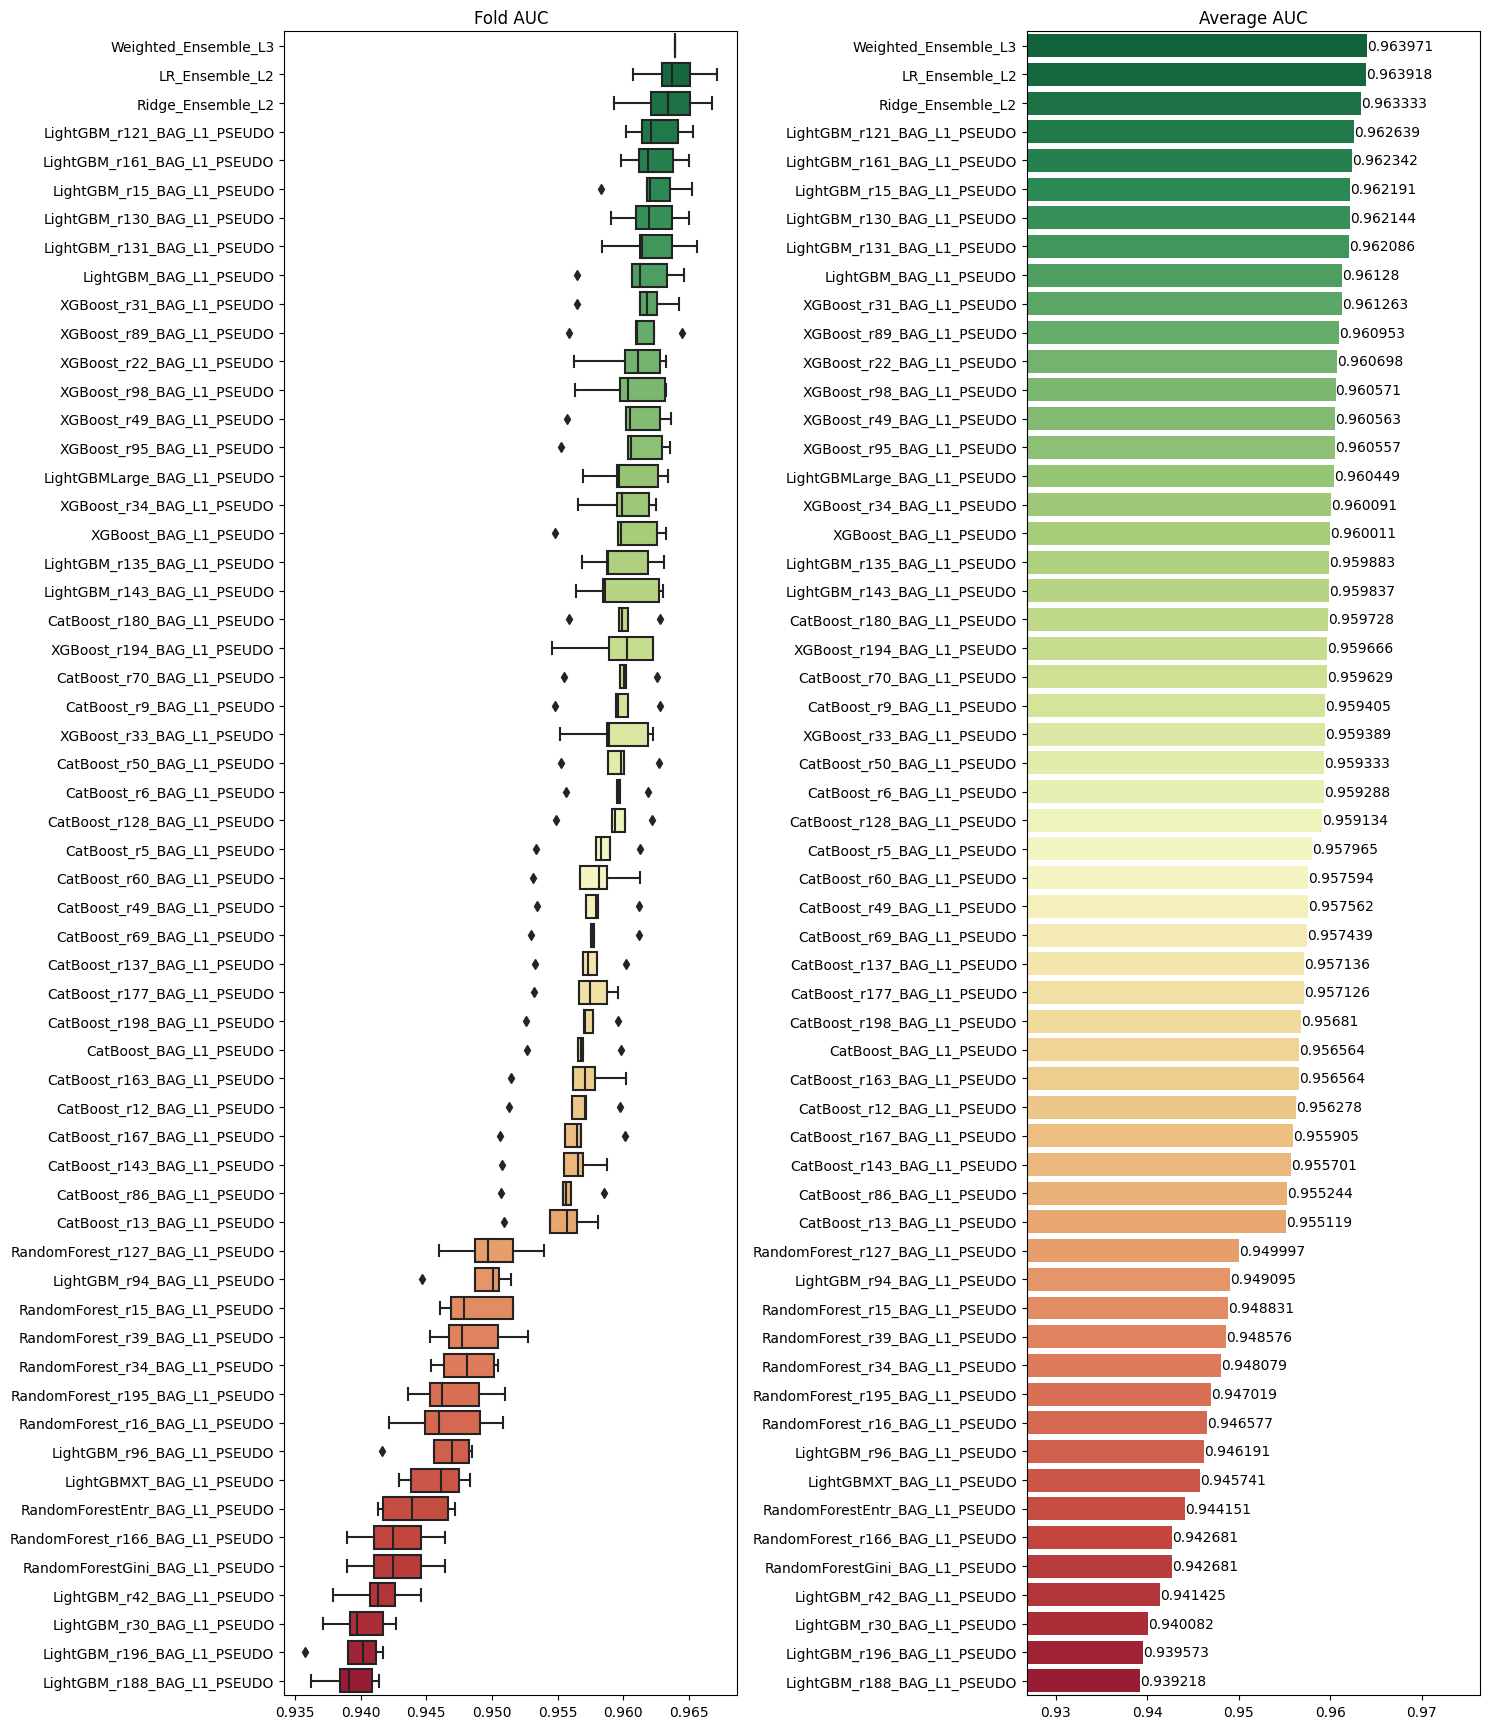

In [23]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()